In [3]:
!pip install pytorch-lightning
!pip install torchmetrics

100%|██████████| 170M/170M [00:05<00:00, 30.2MB/s]


Extracting data/cifar10/cifar-10-python.tar.gz to data/cifar10/


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name     | Type               | Params | Mode 
--------------------------------------------------------
0 | accuracy | MulticlassAccuracy | 0      | train
1 | model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


Files already downloaded and verified


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.7283999919891357     │
│         test_loss         │    0.7794108986854553     │
└───────────────────────────┴───────────────────────────┘

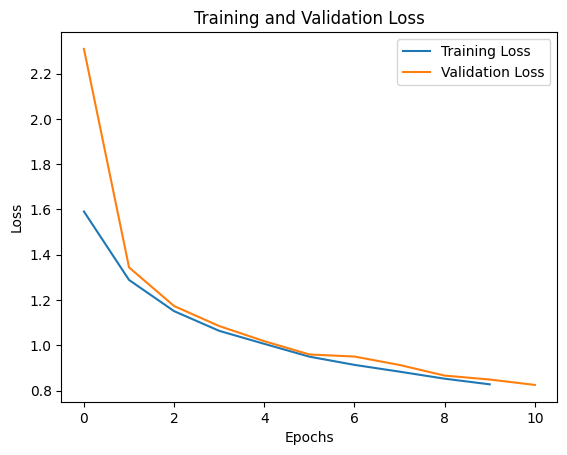

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor, Compose, Normalize, RandomHorizontalFlip, RandomCrop
from torch.utils.data import DataLoader, random_split
import pytorch_lightning as pl
import matplotlib.pyplot as plt
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
import torchmetrics

class CIFAR10Model(pl.LightningModule):
    def __init__(self, lr=1e-3):
        super().__init__()
        self.lr = lr
        self.train_epoch_losses = []
        self.val_epoch_losses = []
        self.train_batch_losses = []
        self.val_batch_losses = []
        self.accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=10)

        # Model architecture
        self.model = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(64 * 8 * 8, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        return self.model(x)

    def compute_loss(self, batch):
        x, y = batch
        y_hat = self(x)
        return F.cross_entropy(y_hat, y), y_hat

    def training_step(self, batch, batch_idx):
        loss, _ = self.compute_loss(batch)
        self.train_batch_losses.append(loss.item())  # Temporarily store each batch loss
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        loss, y_hat = self.compute_loss(batch)
        self.val_batch_losses.append(loss.item())  # Temporarily store each batch loss
        self.accuracy(y_hat, batch[1])
        self.log("val_loss", loss)
        self.log("val_accuracy", self.accuracy)
        return loss

    def on_train_epoch_end(self):
        # Calculate average loss for the epoch and append to epoch losses
        avg_train_loss = sum(self.train_batch_losses) / len(self.train_batch_losses)
        self.train_epoch_losses.append(avg_train_loss)
        self.train_batch_losses = []  # Clear batch losses for the next epoch

    def on_validation_epoch_end(self):
        # Calculate average loss for the epoch and append to epoch losses
        avg_val_loss = sum(self.val_batch_losses) / len(self.val_batch_losses)
        self.val_epoch_losses.append(avg_val_loss)
        self.val_batch_losses = []  # Clear batch losses for the next epoch

    def test_step(self, batch, batch_idx):
        loss, y_hat = self.compute_loss(batch)
        self.accuracy(y_hat, batch[1])
        self.log("test_loss", loss)
        self.log("test_accuracy", self.accuracy)
        return loss

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=self.lr)

def prepare_data(data_path):
    transform = Compose([
        RandomHorizontalFlip(),
        RandomCrop(32, padding=4),
        ToTensor(),
        Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
    ])
    dataset = CIFAR10(data_path, train=True, download=True, transform=transform)
    train_size = int(0.9 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
    return train_dataset, val_dataset

def train_model():
    # Prepare datasets and loaders
    train_dataset, val_dataset = prepare_data("data/cifar10/")
    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=4)

    # Model initialization
    model = CIFAR10Model()

    # Callbacks
    early_stop_callback = EarlyStopping(monitor="val_loss", mode="min", patience=2)
    checkpoint_callback = ModelCheckpoint(monitor="val_loss", mode="min")

    # Trainer setup
    trainer = pl.Trainer(callbacks=[early_stop_callback, checkpoint_callback], max_epochs=10)
    trainer.fit(model, train_loader, val_loader)

    return model, trainer

def test_model(model, trainer):
    # Testing on CIFAR-10 test set
    test_transform = Compose([
        ToTensor(),
        Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
    ])
    test_dataset = CIFAR10("data/cifar10/", train=False, download=True, transform=test_transform)
    test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=4)
    trainer.test(model, test_loader)

def plot_loss_curves(train_losses, val_losses):
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()

# Training the model
model, trainer = train_model()
# Testing the model
test_model(model, trainer)
# Plotting loss curves
plot_loss_curves(model.train_epoch_losses, model.val_epoch_losses)


Using device: cuda
Extracting Imagenette dataset...
Download and extraction complete.
Imagenette Training - Epoch [1/10], Loss: 1.7434
Imagenette Training - Epoch [2/10], Loss: 1.3588
Imagenette Training - Epoch [3/10], Loss: 1.1850
Imagenette Training - Epoch [4/10], Loss: 1.0644
Imagenette Training - Epoch [5/10], Loss: 0.9912
Imagenette Training - Epoch [6/10], Loss: 0.9203
Imagenette Training - Epoch [7/10], Loss: 0.8730
Imagenette Training - Epoch [8/10], Loss: 0.8200
Imagenette Training - Epoch [9/10], Loss: 0.7885
Imagenette Training - Epoch [10/10], Loss: 0.7376
Imagenette model saved as 'imagenette_model.pth'

Training from scratch on CIFAR-10 dataset...


100%|██████████| 170M/170M [00:05<00:00, 30.7MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Scratch Epoch [1/10], Train Loss: 1.6163, Train Acc: 40.62%, Val Loss: 1.3980, Val Acc: 48.78%
Scratch Epoch [2/10], Train Loss: 1.2928, Train Acc: 53.64%, Val Loss: 1.1544, Val Acc: 59.56%
Scratch Epoch [3/10], Train Loss: 1.1435, Train Acc: 59.32%, Val Loss: 1.0426, Val Acc: 62.92%
Scratch Epoch [4/10], Train Loss: 1.0642, Train Acc: 62.16%, Val Loss: 0.9925, Val Acc: 65.20%
Scratch Epoch [5/10], Train Loss: 0.9966, Train Acc: 64.86%, Val Loss: 0.9287, Val Acc: 67.74%
Scratch Epoch [6/10], Train Loss: 0.9132, Train Acc: 67.94%, Val Loss: 0.8574, Val Acc: 70.03%
Scratch Epoch [7/10], Train Loss: 0.8901, Train Acc: 68.75%, Val Loss: 0.8394, Val Acc: 70.73%
Scratch Epoch [8/10], Train Loss: 0.8602, Train Acc: 69.74%, Val Loss: 0.8422, Val Acc: 70.55%
Scratch Epoch [9/10], Train Loss: 0.8396, Train Acc: 70.44%, Val Loss: 0.8341, Val Acc: 70.98%
Scratch Epoch [10/10], Train Loss: 0.8234, Train Acc: 71

<ipython-input-6-c30dfa702a59>:179: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  finetune_model.load_state_dict(torch.load("imagenette_model.pth"), strict=False)


Fine-tune Epoch [1/10], Train Loss: 2.1486, Train Acc: 20.73%, Val Loss: 1.8172, Val Acc: 35.83%
Fine-tune Epoch [2/10], Train Loss: 1.8348, Train Acc: 32.25%, Val Loss: 1.6935, Val Acc: 39.87%
Fine-tune Epoch [3/10], Train Loss: 1.7568, Train Acc: 35.12%, Val Loss: 1.6380, Val Acc: 41.61%
Fine-tune Epoch [4/10], Train Loss: 1.7098, Train Acc: 36.96%, Val Loss: 1.6098, Val Acc: 42.47%
Fine-tune Epoch [5/10], Train Loss: 1.6932, Train Acc: 37.72%, Val Loss: 1.5979, Val Acc: 42.93%
Fine-tune Epoch [6/10], Train Loss: 1.6711, Train Acc: 38.55%, Val Loss: 1.5839, Val Acc: 42.91%
Fine-tune Epoch [7/10], Train Loss: 1.6707, Train Acc: 38.92%, Val Loss: 1.5810, Val Acc: 42.69%
Fine-tune Epoch [8/10], Train Loss: 1.6636, Train Acc: 39.18%, Val Loss: 1.5736, Val Acc: 44.02%
Fine-tune Epoch [9/10], Train Loss: 1.6550, Train Acc: 39.78%, Val Loss: 1.5671, Val Acc: 43.72%
Fine-tune Epoch [10/10], Train Loss: 1.6497, Train Acc: 39.71%, Val Loss: 1.5664, Val Acc: 44.57%


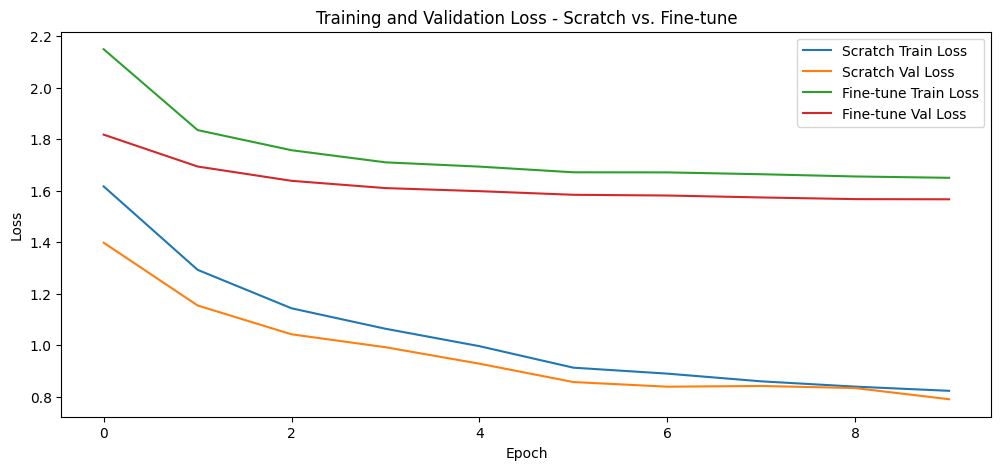

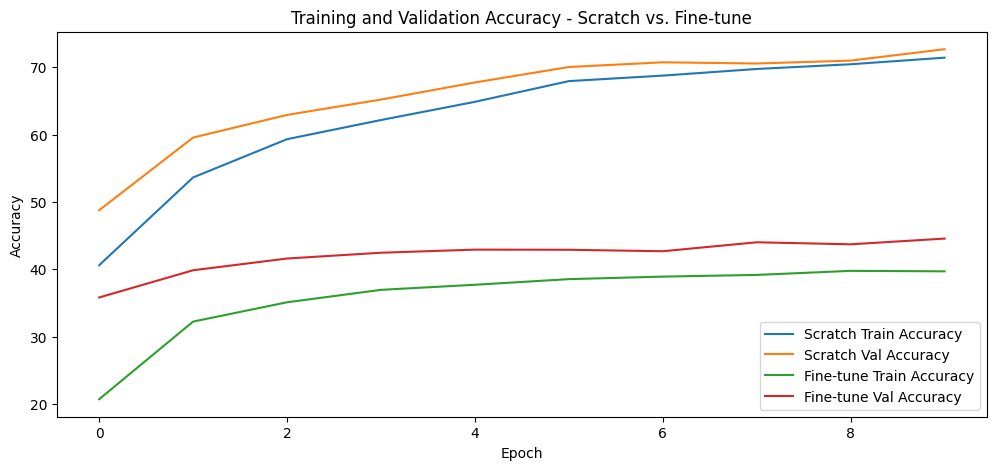


Final Test Accuracy on CIFAR-10:
Scratch Model Test Accuracy: 72.40%
Fine-tuned Model Test Accuracy: 43.52%


In [6]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Define the Basic CNN model
class BasicCNN(nn.Module):
    def __init__(self):
        super(BasicCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(256 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, 10)
        self.dropout = nn.Dropout(0.4)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = x.view(-1, 256 * 4 * 4)
        x = self.dropout(F.relu(self.fc1(x)))
        return self.fc2(x)

# Part 1: Download and Train on Imagenette, Save Pre-trained Weights
print("Downloading and training on Imagenette dataset...")

# Download and extract Imagenette if it doesn't exist
imagenette_url = "https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-320.tgz"
if not os.path.exists('./imagenette2-320'):
    import urllib.request
    import tarfile
    print("Downloading Imagenette dataset...")
    urllib.request.urlretrieve(imagenette_url, "imagenette2-320.tgz")
    print("Extracting Imagenette dataset...")
    with tarfile.open("imagenette2-320.tgz", "r:gz") as tar:
        tar.extractall()
    print("Download and extraction complete.")

# Data preparation for Imagenette
imagenette_transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Resize to match CIFAR-10 dimensions
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load the Imagenette dataset
train_imagenette = datasets.ImageFolder(root='./imagenette2-320/train', transform=imagenette_transform)
imagenette_loader = DataLoader(train_imagenette, batch_size=64, shuffle=True)

# Initialize the model, loss function, and optimizer
imagenette_model = BasicCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(imagenette_model.parameters(), lr=0.0001)
num_epochs = 10

# Training loop for Imagenette
for epoch in range(num_epochs):
    imagenette_model.train()
    total_loss = 0
    for images, labels in imagenette_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = imagenette_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(imagenette_loader)
    print(f"Imagenette Training - Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

# Save the trained Imagenette model
torch.save(imagenette_model.state_dict(), "imagenette_model.pth")
print("Imagenette model saved as 'imagenette_model.pth'")

# Part 2: Train from Scratch on CIFAR-10
print("\nTraining from scratch on CIFAR-10 dataset...")

# CIFAR-10 data preparation
cifar10_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR10(root='./data', train=True, transform=cifar10_transform, download=True)
test_dataset = datasets.CIFAR10(root='./data', train=False, transform=cifar10_transform, download=True)

# Split training dataset into training and validation sets
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Create Data Loaders
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

# Initialize the model from scratch, criterion, and optimizer
scratch_model = BasicCNN().to(device)
optimizer = optim.Adam(scratch_model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
train_loss_history_scratch, val_loss_history_scratch = [], []
train_acc_history_scratch, val_acc_history_scratch = [], []

# Training loop for CIFAR-10 from scratch
for epoch in range(num_epochs):
    scratch_model.train()
    train_loss, correct, total = 0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = scratch_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    avg_train_loss = train_loss / len(train_loader)
    train_accuracy = 100 * correct / total
    train_loss_history_scratch.append(avg_train_loss)
    train_acc_history_scratch.append(train_accuracy)

    # Validation phase
    scratch_model.eval()
    val_loss, correct_val, total_val = 0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = scratch_model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = 100 * correct_val / total_val
    val_loss_history_scratch.append(avg_val_loss)
    val_acc_history_scratch.append(val_accuracy)

    print(f"Scratch Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, "
          f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")

    scheduler.step()

# Part 3: Fine-tune using Pre-trained Imagenette Weights on CIFAR-10
print("\nFine-tuning pre-trained Imagenette model on CIFAR-10 dataset...")

# Load the Imagenette pre-trained model and adjust the output layer
finetune_model = BasicCNN().to(device)
finetune_model.load_state_dict(torch.load("imagenette_model.pth"), strict=False)

# Freeze all layers except the fully connected layers
for param in finetune_model.parameters():
    param.requires_grad = False
finetune_model.fc1.requires_grad = True
finetune_model.fc2 = nn.Linear(256, 10).to(device)  # Adjust output layer for CIFAR-10
finetune_model.fc2.requires_grad = True

# Fine-tuning setup
optimizer = optim.Adam(filter(lambda p: p.requires_grad, finetune_model.parameters()), lr=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
train_loss_history_finetune, val_loss_history_finetune = [], []
train_acc_history_finetune, val_acc_history_finetune = [], []

# Fine-tuning loop
for epoch in range(num_epochs):
    finetune_model.train()
    train_loss, correct, total = 0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = finetune_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    avg_train_loss = train_loss / len(train_loader)
    train_accuracy = 100 * correct / total
    train_loss_history_finetune.append(avg_train_loss)
    train_acc_history_finetune.append(train_accuracy)

    # Validation phase
    finetune_model.eval()
    val_loss, correct_val, total_val = 0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = finetune_model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = 100 * correct_val / total_val
    val_loss_history_finetune.append(avg_val_loss)
    val_acc_history_finetune.append(val_accuracy)

    print(f"Fine-tune Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, "
          f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")

    scheduler.step()

# Plot Training and Validation Losses for both approaches
plt.figure(figsize=(12, 5))
plt.plot(train_loss_history_scratch, label="Scratch Train Loss")
plt.plot(val_loss_history_scratch, label="Scratch Val Loss")
plt.plot(train_loss_history_finetune, label="Fine-tune Train Loss")
plt.plot(val_loss_history_finetune, label="Fine-tune Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss - Scratch vs. Fine-tune")
plt.legend()
plt.show()

# Plot Training and Validation Accuracy for both approaches
plt.figure(figsize=(12, 5))
plt.plot(train_acc_history_scratch, label="Scratch Train Accuracy")
plt.plot(val_acc_history_scratch, label="Scratch Val Accuracy")
plt.plot(train_acc_history_finetune, label="Fine-tune Train Accuracy")
plt.plot(val_acc_history_finetune, label="Fine-tune Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy - Scratch vs. Fine-tune")
plt.legend()
plt.show()

# Testing Phase for both models
print("\nFinal Test Accuracy on CIFAR-10:")

# Test the model trained from scratch
scratch_model.eval()
correct_test, total_test = 0, 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = scratch_model(images)
        _, predicted = torch.max(outputs, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()
print(f'Scratch Model Test Accuracy: {100 * correct_test / total_test:.2f}%')

# Test the fine-tuned model
finetune_model.eval()
correct_test, total_test = 0, 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = finetune_model(images)
        _, predicted = torch.max(outputs, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()
print(f'Fine-tuned Model Test Accuracy: {100 * correct_test / total_test:.2f}%')
